In [44]:
%%capture
try:
    import pandas
except ImportError as e:
    !pip install pandas 

try: 
    import numpy
except ImportError as e:
    !pip install numpy 

try:
    import matplotlib
except ImportError as e:
    !pip install matplotlib 

try:
    import sklearn
except ImportError as e:
    !pip install scikit-learn

try:
    import scipy
except ImportError as e:
    !pip install scipy

try:
    import torch
except ImportError as e:
    !pip install torch

try:
    import tqdm
except ImportError as e:
    !pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor

## Loading the Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv',
                 parse_dates=['date'])
df = df.set_index('date')
df.index.freq = pd.infer_freq(df.index)

## Training Configuration 

In [18]:
TRAIN_FRACTION = 0.8
CONTEXT_LENGTH = 512
FORECAST_LENGTH = 96
STRIDE=1
N_SAMPLE_TO_PLOT = 4
PAST_WINDOW = 100

## Preparing the Training Data

Data prepared from the data with a history and Forecast length `512` and `96` respectively, in a rolling window fashion.

In [26]:
data = df.OT.values

x = list()

for i in range(1, len(data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE):
    x.append(data[i:(i + CONTEXT_LENGTH + FORECAST_LENGTH)])

x = np.array(x).astype(float)

X, y = x[:, :CONTEXT_LENGTH], x[:, CONTEXT_LENGTH:]

train_length = int(TRAIN_FRACTION * len(X))

trainX, testX = X[:train_length], X[train_length:]
trainY, testY = y[:train_length], y[train_length:]

## Instantiating the RandomForestRegressor

Please feel free to change the `n_estimators` and `max_depth` parameter, and see their impact on the model forecast.

In [27]:
rf_model = RandomForestRegressor(n_estimators=50, 
                                 max_depth=5, 
                                 n_jobs=4, 
                                 verbose=1)

In [28]:
rf_model.fit(trainX, trainY)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   49.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   59.3s finished


RandomForestRegressor(max_depth=5, n_estimators=50, n_jobs=4, verbose=1)

In [29]:
predictY = rf_model.predict(testX)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [30]:
rmse = np.mean(np.sqrt(np.mean(np.square(testY - predictY), axis=-1)))
print(f"Prediction RMSE = {rmse:.4f}")

Prediction RMSE = 2.3637


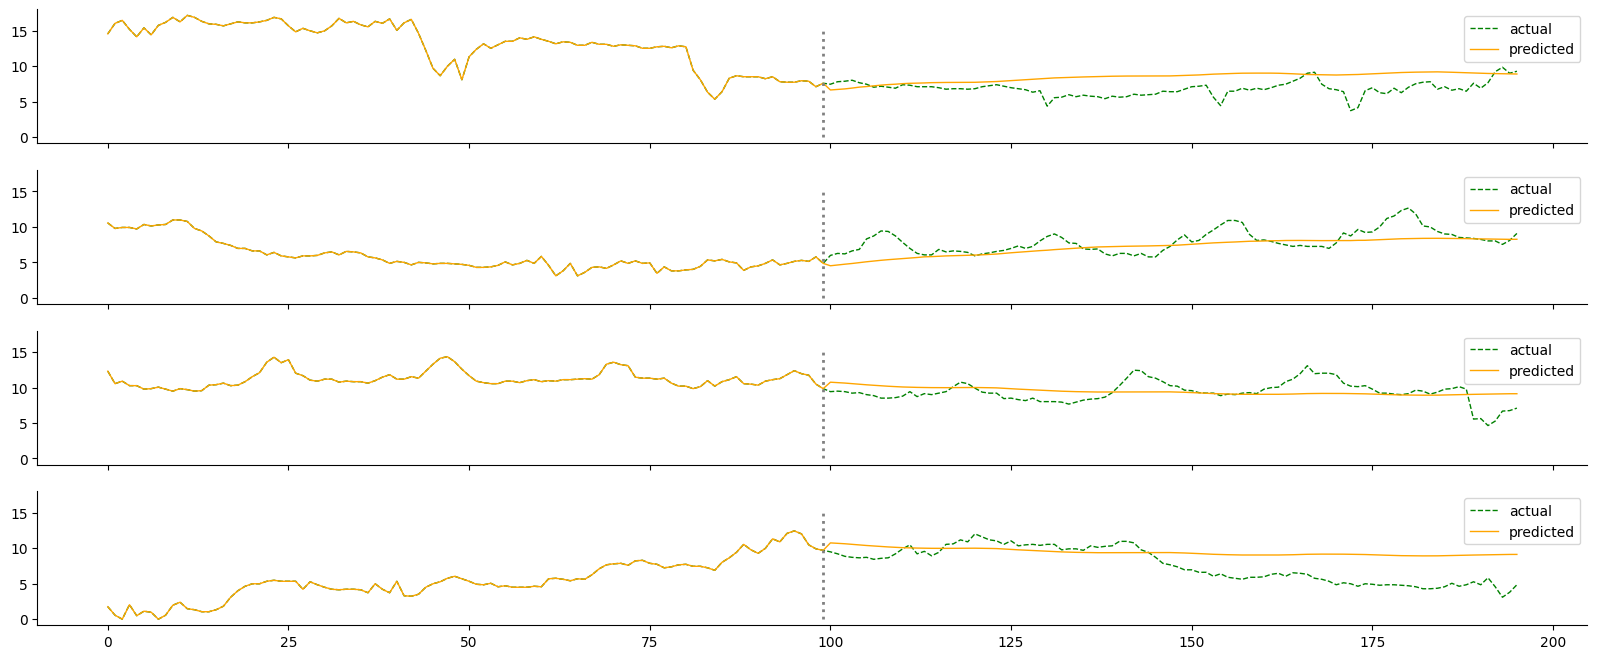

In [143]:
random_indices = np.random.default_rng(1).choice(len(testY), N_SAMPLE_TO_PLOT, replace=False)

fig, axs = plt.subplots(N_SAMPLE_TO_PLOT, 1, sharex='col', sharey=True, figsize=(20, 2*N_SAMPLE_TO_PLOT))

for i, index in enumerate(random_indices):
    n_history = min(PAST_WINDOW, CONTEXT_LENGTH)
    y_true = np.concatenate([testX[index, -n_history:], testY[index]])
    y_pred = np.concatenate([testX[index, -n_history:], predictY[index]])
    axs[i].plot(y_true, color='green', linestyle='dashed', linewidth=1, label='actual')
    axs[i].plot(y_pred, color='orange', linewidth=1, label='predicted')
    for s in ['top', 'right']:
        axs[i].spines[s].set_visible(False)
    axs[i].plot([n_history-1, n_history-1], [0, 15], linewidth=2, linestyle='dotted', color='gray') 
    axs[i].legend()

## Neural Network Example

In [71]:
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [34]:
border1s = [0,            
            12 * 30 * 24 - CONTEXT_LENGTH, 
            12 * 30 * 24 + 4 * 30 * 24 - CONTEXT_LENGTH]
border2s = [12 * 30 * 24, 
            12 * 30 * 24 + 4 * 30 * 24, 
            12 * 30 * 24 + 8 * 30 * 24 ]

In [36]:
data = df.OT.values.reshape(-1, 1)
scaler = StandardScaler()
train_data = data[border1s[0]:border2s[0],:]
scaler = StandardScaler()
scaler.fit(train_data)

data = scaler.transform(data)
train_data = data[border1s[0]:border2s[0],:]
valid_data = data[border1s[1]:border2s[1],:]
test_data = data[border1s[2]:border2s[2],:]

In [196]:
train_io_pairs = np.array([train_data[i:(i + CONTEXT_LENGTH + FORECAST_LENGTH)] 
                           for i in range(1, len(train_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)])
X_train = train_io_pairs[:, :CONTEXT_LENGTH]
y_train = train_io_pairs[:, CONTEXT_LENGTH:]

valid_io_pairs = np.array([valid_data[i:(i + CONTEXT_LENGTH + FORECAST_LENGTH),0] 
                           for i in range(1, len(valid_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)])

X_valid = valid_io_pairs[:, :CONTEXT_LENGTH]
y_valid = valid_io_pairs[:, CONTEXT_LENGTH:]

test_io_pairs = np.array([test_data[i:(i + CONTEXT_LENGTH + FORECAST_LENGTH), 0] 
                          for i in range(1, len(test_data) - CONTEXT_LENGTH - FORECAST_LENGTH, STRIDE)])
X_test = test_io_pairs[:, :CONTEXT_LENGTH]
y_test = test_io_pairs[:, CONTEXT_LENGTH:]

## Dataset Class
This is an important class, as it prepare the data for the model.
Any online data clearning, reshaping, augmentation implementation, can be incorporated in this `Dataset` class instance.

In [197]:
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

## Simple 3 layer MLP


In [214]:
class CreateModel(nn.Module):
    def __init__(self,
                 in_features,
                 units,
                 out_features):
        super(CreateModel, self).__init__()
        self.l1 = nn.Linear(in_features, units)
        self.l2 = nn.Linear(units, units)
        self.l3 = nn.Linear(units, out_features)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        x = self.l3(x)
        x = x.unsqueeze(-1)
        return x

## Preparing the data and model for training

In [254]:
HIDDEN_UNITS = 16
EPOCHS = 25

torch.manual_seed(42)
tr_data = Data(X_train, y_train)
tr_loader = DataLoader(dataset=tr_data, batch_size=64, shuffle=True)
nn_model = CreateModel(CONTEXT_LENGTH, HIDDEN_UNITS, FORECAST_LENGTH)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), 
                             lr=0.0001)

In [255]:
loss_list = []
use_l1 = False

for t in range(EPOCHS):
    running_loss = 0
    pbar = tqdm(tr_loader)
    for i, data in enumerate(pbar):
        x_batch, y_batch = data
        y_pred = nn_model(x_batch)
        loss = criterion(y_pred, y_batch)
        if use_l1:
            l1_parameters = []
            for parameter in nn_model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1_loss = torch.abs(torch.cat(l1_parameters)).mean()
            loss = loss + l1_loss
        model.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_description(f"Epoch[{t+1} : {i}/{len(tr_loader)}]: train_loss {running_loss/(i+1):.4f}")
    loss_list.append(running_loss/len(tr_loader))

Epoch[25 : 125/126]: train_loss 0.3394: 100%|████████████████████████████████████████████████████| 126/126 [00:00<00:00, 296.01it/s]


## Plotting the loss convergence

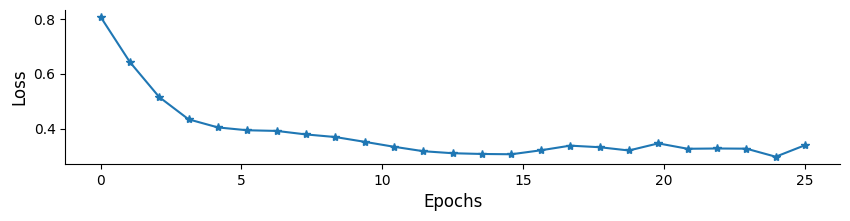

In [256]:
step = np.linspace(0, EPOCHS, EPOCHS)
fig, ax = plt.subplots(1, 1, figsize=(10,2))
ax.plot(step, np.array(loss_list), marker='*')
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
plt.show()

In [257]:
yp_test = nn_model(torch.from_numpy(X_test).float()).to('cpu').detach().numpy()

In [258]:
y_test_ = np.array([scaler.inverse_transform(y_[..., np.newaxis]) for y_ in y_test])
yp_test_ = np.array([scaler.inverse_transform(y_) for y_ in yp_test])

rmse = np.mean(np.sqrt(np.mean(np.square(y_test_ - yp_test_), axis=1)))
print(f"Prediction RMSE = {rmse:.4f}")

Prediction RMSE = 3.6431


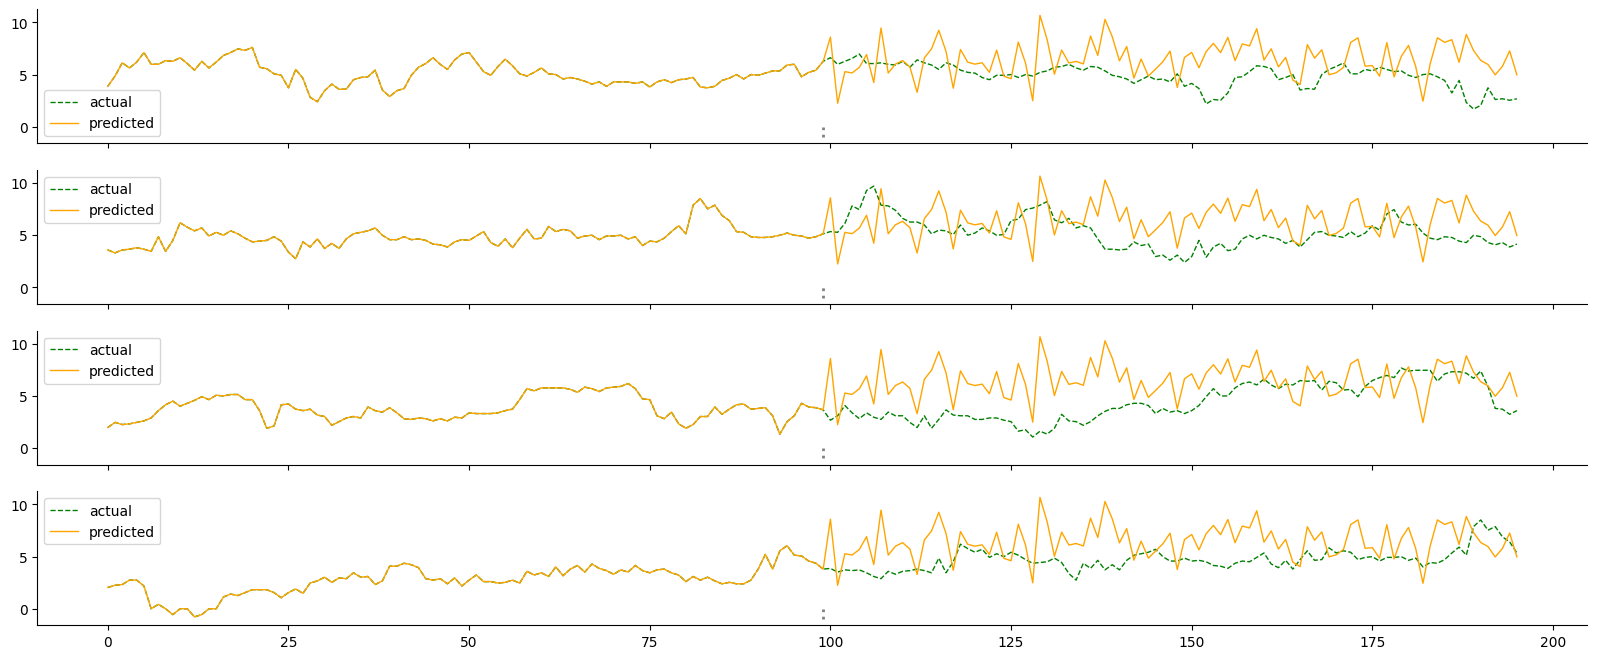

In [259]:
random_indices = np.random.default_rng(1).choice(len(y_test), N_SAMPLE_TO_PLOT, replace=False)

fig, axs = plt.subplots(N_SAMPLE_TO_PLOT, 1, sharex='col', figsize=(20, 2*N_SAMPLE_TO_PLOT))

for i, index in enumerate(random_indices):
    n_history = min(PAST_WINDOW, CONTEXT_LENGTH)
    x_hist = scaler.inverse_transform(X_test[index, -n_history:].reshape(-1, 1))
    y_true = np.concatenate([x_hist[..., 0], y_test_[index, :, 0]], axis=0)
    y_true = y_true[..., np.newaxis]
    y_pred = np.concatenate([x_hist[..., 0], yp_test_[index, :, 0]], axis=0)
    y_pred = y_pred[..., np.newaxis]
    axs[i].plot(y_true, color='green', linestyle='dashed', linewidth=1, label='actual')
    axs[i].plot(y_pred, color='orange', linewidth=1, label='predicted')
    for s in ['top', 'right']:
        axs[i].spines[s].set_visible(False)
    axs[i].plot([n_history-1, n_history-1], [-1, 0], linewidth=2, linestyle='dotted', color='gray') 
    axs[i].legend()